# Lista 1: EDA
1. Pobieramy zbiór danych

In [2]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

In [3]:
bank_marketing = fetch_ucirepo(id=222)

X = bank_marketing.data.features
y = bank_marketing.data.targets
# Od razu dokonujemy podziau na train test val
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# zobaczmy jak to wygląda
print(X.head(3))
print(y.head(3))

print(bank_marketing.metadata)
print(bank_marketing.variables)

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   

  contact  day_of_week month  duration  campaign  pdays  previous poutcome  
0     NaN            5   may       261         1     -1         0      NaN  
1     NaN            5   may       151         1     -1         0      NaN  
2     NaN            5   may        76         1     -1         0      NaN  
    y
0  no
1  no
2  no
{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe 

Zbiór danych to informacje o klientach, którzy rozmawiali z pracownikami banku próbującymi nakłonić do wzięcia kredytu. Naszą etykietą binarną jest odpowiedź, czy dany klient po rozmowie taki kredyt wziął czy też nie.

### Mamy tutaj 16 cech:
Numeryczne:
- age - wiek
- balance - roczny dochód
- duration - długość rozmowy
- campaing - ile razy klient rozmawiał z bankiem (wliczając tą ostatnią)
- pdays - ile dni minęło od poprzedniej rozmowy z klientem (-1 jeżeli to pierwsza)
- previous - liczba rozmów odbyta przed tą ostatnią

Binarne:
- default - czy klient ma niespłacony kredyt
- housing - czy ma kredyt na mieszkanie
- loan - czy ma kredyt osobisty 

Kategoryczne:
- job - zawód 
- marital - status małżeński
- education - wykształcenie
- contact - czym się kontaktował klient (telefon komórkowy vs stacjonarny)
- poutcome - efekt poprzedniej rozmowy (porażka/sukces/nieistniała)

Daty:
- day of week - dzień tygodnia ostatniej rozmowy
- month - miesiąc ostatniej rozmowy (kategorycznie, 3 pierwsze litery miesiąca)

Po samym przeczytaniu czym są cechy od razu widzimy że część z nich ze sobą koreluje, bądź jest niepotrzebna a nawet szkodząca dla modelu ale o tym później.

In [4]:
# Sprawdzenie liczby pustych rekordów (NaN) w każdej kolumnie
print(X.isna().sum())

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64


### Puste rekordy:
Z bank_marketing.variables widzimy, że poutcome i pdays mają brakujące wartości, przy czym poutcome oznaczamy  jako Nan, a pdays jako -1. (przeczytałem opis datasetu, nie licząc pdays wszystkie brakujące rekordy zapisywane są jako NaN)
Odnoszą się one do faktu, że dany klient nie kontatkował się z bankiem wcześniej niż ten raz gdy zebrano dane. oczywiście cechy takie jak previous też do tego nawiązują, ale że jest to cecha numeryczna to po prostu mają wtedy wartość zero.


Dodatkowo z kodu powyżej widzimy że kolumny job, education, i contact posiadają puste rekordy, którymi będziemy się musieli zająć. W odróżnieniu od dwóch cech wspomnianych wyżej, te są po prostu brakami do naprawy.

### Korelacje:
Sprowadzimy  wsxzystkie dane do wartości liczbowych, po czym wykonamy testy statystyczne aby znaleźć korelacje między cechami

1. 
job, education oraz contact uzupełnimy w oparciu o rozkład prawdopodobieństwa kategorii w pełych rekordach tych cech, aby nie wzmacniać jednej, naczęstszej/najśredniejszej wartoś

In [5]:
def fillna_with_distribution(df, columns):
	for col in columns:		# rozkad liczymy na x_train
		value_counts = X_train[col].value_counts(normalize=True, dropna=True)
		missing = df[col].isna()
		if missing.sum() > 0:
			filled_values = np.random.choice(
				value_counts.index,
				size=missing.sum(),
				p=value_counts.values
			)
			df.loc[missing, col] = filled_values
	return df

X = fillna_with_distribution(X, ['job', 'education', 'contact'])


2. 
poutcome zawsze daje Nan, gdy klient nie rozmawiał wcześniej z bankiem, więc można dodać do poutcome kategorię "none" zastępującą Nan, gdy rozmówca miał do czynienia z bankiem tylko ten jeden raz.

In [6]:
mask = (X['poutcome'].isna())
X.loc[mask, 'poutcome'] = 'none'

3.
-1 troche odstaje wartością od reszty liczb w pdays. Stworzymy nową kolumnę: Is_first_time, która nam powie czy klient rozmawia z bankiem pierwszy raz czy też kolejny (cecha binarna), a -1 w starej kolumnie wykonujemy imputację knn.

In [7]:
X['is_first_time'] = (X['pdays'] == -1).astype(int)

# Zamień -1 na np.nan w pdays
for df in [X_train, X_val, X_test, X]:
    df['pdays'] = df['pdays'].replace(-1, np.nan)

# Fit imputer tylko na X_train
imputer = KNNImputer(n_neighbors=5)
imputer.fit(X_train[['pdays']])

# wrzucamy do X_knn dla sprawdzenia jak dziala
X_knn = X.copy()
X_knn['pdays'] = imputer.transform(X_knn[['pdays']])
print(X_knn.isna().sum())

age              0
job              0
marital          0
education        0
default          0
balance          0
housing          0
loan             0
contact          0
day_of_week      0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome         0
is_first_time    0
dtype: int64


In [8]:
X_knn.head(10)
X_knn['pdays'].unique()

array([225.08976306, 151.        , 166.        ,  91.        ,
        86.        , 143.        , 147.        ,  89.        ,
       140.        , 176.        , 101.        , 174.        ,
       170.        , 167.        , 195.        , 165.        ,
       129.        , 188.        , 196.        , 172.        ,
       118.        , 119.        , 104.        , 171.        ,
       117.        , 164.        , 132.        , 131.        ,
       123.        , 159.        , 186.        , 111.        ,
       115.        , 116.        , 173.        , 178.        ,
       110.        , 152.        ,  96.        , 103.        ,
       150.        , 175.        , 193.        , 181.        ,
       185.        , 154.        , 145.        , 138.        ,
       126.        , 180.        , 109.        , 158.        ,
       168.        ,  97.        , 182.        , 127.        ,
       130.        , 194.        , 125.        , 105.        ,
       102.        ,  26.        , 179.        ,  28.  

Z tego co widzę to ten knn tak średnio zadziałał, bo wszystkie -1 zamienił na jakąś tam wartość zamiast robić osobne wartości w zależności od sąsiedztwa co pewnie jest spowodowane tym, że większość wartości to -1. Zostaniemy w takim razie przy medianie policzonej na zbiorze testowym.

In [9]:
median_pdays = X_train.loc[X_train['pdays'].notna(), 'pdays'].median()
X.loc[X['pdays'].isna(), 'pdays'] = median_pdays.round(0)
X['pdays'] = X['pdays'].astype(int)
print(f"Mediana pdays z X_train: {median_pdays}")
print(X['pdays'].isna().sum())

Mediana pdays z X_train: 195.0
0


Tera jest git. Następna w kolejności jest konwersja wszystkich wartości na liczby, głównie chodzi o cechy binarne i kategoryczne, zobaczmy jak to narazie wygląda:

In [10]:
X.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,is_first_time
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,195,0,none,1
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,195,0,none,1


Dla job,marital,default,housing,loan,contact zrobimy one hot encoding , dla education zrobimy label encoding bo wyksztasłcenie jest w postaci hierarchii a month zrobimy jako cyclic encoding, dodając tabelę monnth sin i month cos

In [11]:
# One-hot encoding 
dummy_cols = ['job', 'marital', 'poutcome']
X = pd.get_dummies(X, columns=dummy_cols, drop_first=False)

for col in ['default', 'housing', 'loan','contact']:
    if col == 'contact': 
        X[col] = X[col].map({'telephone': 1, 'cellular': 0})
    else:
        X[col] = X[col].map({'yes': 1, 'no': 0})


# label encoding dla education: 0 - primary, 1 - secondary, 2 - tertiary
enc_education = LabelEncoder()
X['education'] = enc_education.fit_transform(X['education'])

# cyclic encoding dla month
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_to_num = {month: idx for idx, month in enumerate(months)}
X['month_num'] = X['month'].map(month_to_num)
X['month_sin'] = np.sin(2 * np.pi * X['month_num'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month_num'] / 12)

X = X.drop(columns=['month', 'month_num'])


In [12]:
pd.set_option('display.max_columns', None)
X.info()
X.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                45211 non-null  int64  
 1   education          45211 non-null  int64  
 2   default            45211 non-null  int64  
 3   balance            45211 non-null  int64  
 4   housing            45211 non-null  int64  
 5   loan               45211 non-null  int64  
 6   contact            45211 non-null  int64  
 7   day_of_week        45211 non-null  int64  
 8   duration           45211 non-null  int64  
 9   campaign           45211 non-null  int64  
 10  pdays              45211 non-null  int64  
 11  previous           45211 non-null  int64  
 12  is_first_time      45211 non-null  int64  
 13  job_admin.         45211 non-null  bool   
 14  job_blue-collar    45211 non-null  bool   
 15  job_entrepreneur   45211 non-null  bool   
 16  job_housemaid      452

,age,education,default,balance,housing,loan,contact,day_of_week,duration,campaign,pdays,previous,is_first_time,month_sin,month_cos
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,4.521100e+04
mean,40.936210,1.149897,0.018027,1362.272058,0.555838,0.160226,0.089602,15.806419,258.163080,2.763841,200.401849,0.580323,0.817367,0.251128,-3.980684e-01
std,10.618762,0.665036,0.133049,3044.765829,0.496878,0.366820,0.285614,8.322476,257.527812,3.098021,50.597875,2.303441,0.386369,0.640129,6.072296e-01
min,18.000000,0.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000e+00
25%,33.000000,1.000000,0.000000,72.000000,0.000000,0.000000,0.000000,8.000000,103.000000,1.000000,195.000000,0.000000,1.000000,-0.500000,-8.660254e-01
50%,39.000000,1.000000,0.000000,448.000000,1.000000,0.000000,0.000000,16.000000,180.000000,2.000000,195.000000,0.000000,1.000000,0.500000,-5.000000e-01
75%,48.000000,2.000000,0.000000,1428.000000,1.000000,0.000000,0.000000,21.000000,319.000000,3.000000,195.000000,0.000000,1.000000,0.866025,6.123234e-17
max,95.000000,2.000000,1.000000,102127.000000,1.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000,1.000000,1.000000e+00


Wszystkie dane mamy zapisane jako liczby, to teraz możemy poszukać korelacji i outlierów oraz kolumn, które nie są potrzebne do nauki.

4. 
Korelacje

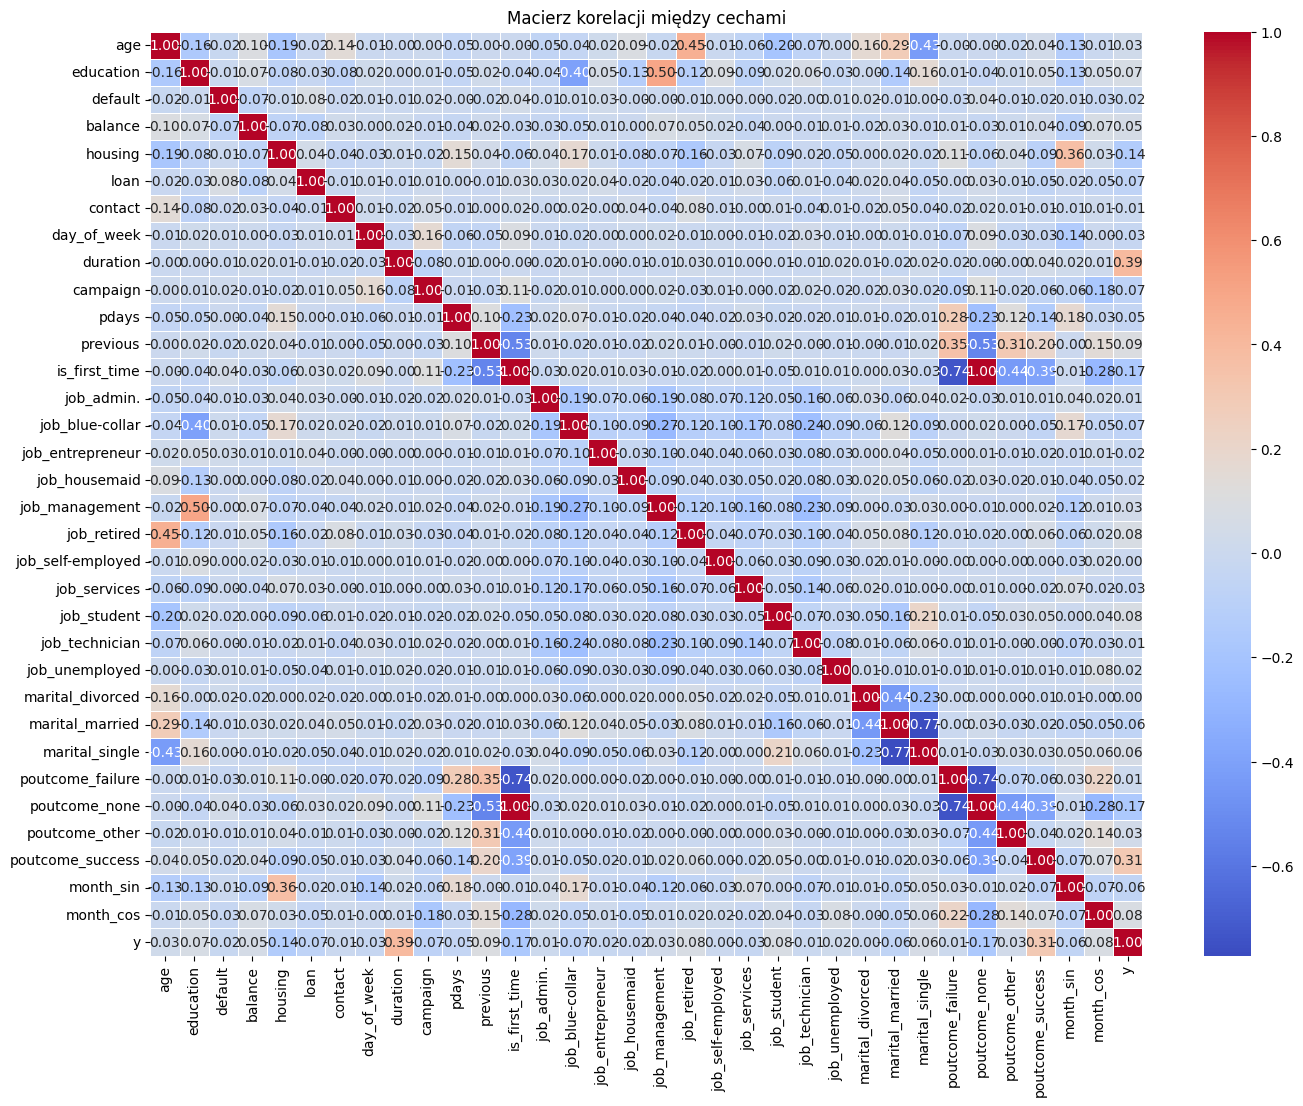

In [13]:
X['y'] = y['y'].map({'yes': 1, 'no': 0})    # chcemy zobaczyc tez korelacje z targetem
plt.figure(figsize=(16, 12))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Macierz korelacji między cechami")
plt.show()
X.drop(columns=['y'], inplace=True)

- Usuwamy duration bo mocno koreluje z y a przed rozmową i tak nie jesteśmy w stanie go znać wiec useless
- Usuwamy poutcome_none i pdays bo mamy is_first time i previous
- Usuwamy marital_married aby zredukować korelację w kolumnach marital
- wszystkie poutcome korelują z is_first_time więc go usunę, jednak dodanie go nie było potrzebne

narazie tyle, najwyżej potem coś jeszcze zmienimy
 


In [15]:
X.drop(columns=['duration','poutcome_none','is_first_time','marital_married','pdays'], inplace=True)  

KeyError: "['duration', 'poutcome_none', 'marital_married', 'pdays'] not found in axis"